<a href="https://colab.research.google.com/github/MKeel1ng/CELL-GAN/blob/master/wgan_gp_64_L_relu_wd_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN-GP overriding `Model.train_step`

**Author:** [A_K_Nain](https://twitter.com/A_K_Nain)<br>
**Date created:** 2020/05/9<br>
**Last modified:** 2020/05/9<br>
**Description:** Implementation of Wasserstein GAN with Gradient Penalty.

## Wasserstein GAN (WGAN) with Gradient Penalty (GP)

The original [Wasserstein GAN](https://arxiv.org/abs/1701.07875) leverages
the Wasserstein distance to produce a value function that has better theoretical
properties than the value function used in the original GAN paper. WGAN requires that
the discriminator (aka the critic) lie within the space of 1-Lipschitz functions.
The authors proposed the idea of weight clipping to achieve this constraint. Though
weight clipping works, it can be a problematic way to enforce 1-Lipschitz constraint
and can cause undesirable behavior, e.g. a very deep WGAN discriminator (critic)
often fails to converge.

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf) proposed an alternative to weight
clipping to ensure smooth training. Instead of clipping the weights, the authors
proposed a "gradient penalty": adding a loss term that keeps the L2
norm of the discriminator gradients close to 1.


## Setup


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Prepare Fashion-MNIST data

We will be using the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset
in this example to demonstrate the training of WGAN-GP. Each sample in this dataset is a 28x28
grayscale image associated with a label from 10 classes (e.g. Trouser, Pullover, Sneaker, etc.)


In [4]:
IMG_SHAPE = (64, 64, 3)
BATCH_SIZE = 256

# Size of noise vector
noise_dim = 256
content='/content/drive/My Drive/ThesisDL/CELL_GAN/MF_CELLS/'



In [ ]:
import os
n = os.listdir(content)

clean_names=[name for name in n if name[0]=='c']
print(len(clean_names))


5772


In [ ]:
#ims=np.zeros((len(clean_names)*4, 128, 128, 3)).astype('float32')
count=0
import cv2
for i,im in enumerate(clean_names):
  
  im=cv2.imread(content+im)/255
  im=cv2.resize(im,(128,128))
  ims[count,:,:,:]=im
  count+=1

  ims[count,:,:,:]=cv2.flip(im, -1)
  count+=1

  ims[count,:,:,:]=cv2.flip(im, 1)
  count+=1

  ims[count,:,:,:]=cv2.flip(im, 0)
  count+=1
  print(count/(len(clean_names)*4)*100)



In [ ]:
#np.save(content+'ims_128x',ims)

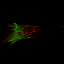

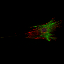

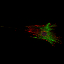

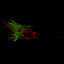

(23088, 64, 64, 3)


In [5]:
from google.colab.patches import cv2_imshow

train_images=np.load(content+'ims_64x.npy')
cv2_imshow(train_images[0,:,:,:]*255)
cv2_imshow(train_images[1,:,:,:]*255)
cv2_imshow(train_images[2,:,:,:]*255)
cv2_imshow(train_images[3,:,:,:]*255)
print(train_images.shape)

In [6]:
from keras import backend as K
from keras.engine.topology import Layer

class Attention(Layer):
    def __init__(self, ch, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.channels = ch
        self.filters_f_g = self.channels // 8
        self.filters_h = self.channels

    def build(self, input_shape):
        kernel_shape_f_g = (1, 1) + (self.channels, self.filters_f_g)
        print(kernel_shape_f_g)
        kernel_shape_h = (1, 1) + (self.channels, self.filters_h)

        # Create a trainable weight variable for this layer:
        self.gamma = self.add_weight(name='gamma', shape=[1], initializer='zeros', trainable=True)
        self.kernel_f = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_f')
        self.kernel_g = self.add_weight(shape=kernel_shape_f_g,
                                        initializer='glorot_uniform',
                                        name='kernel_g')
        self.kernel_h = self.add_weight(shape=kernel_shape_h,
                                        initializer='glorot_uniform',
                                        name='kernel_h')
        self.bias_f = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_F')
        self.bias_g = self.add_weight(shape=(self.filters_f_g,),
                                      initializer='zeros',
                                      name='bias_g')
        self.bias_h = self.add_weight(shape=(self.filters_h,),
                                      initializer='zeros',
                                      name='bias_h')
        super(Attention, self).build(input_shape)
        # Set input spec.
        self.input_spec = tf.keras.layers.InputSpec(ndim=4,
                                    axes={3: input_shape[-1]})
        self.built = True


    def call(self, x):
        def hw_flatten(x):
            return K.reshape(x, shape=[K.shape(x)[0], K.shape(x)[1]*K.shape(x)[2], K.shape(x)[-1]])

        f = K.conv2d(x,
                     kernel=self.kernel_f,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        f = K.bias_add(f, self.bias_f)
        g = K.conv2d(x,
                     kernel=self.kernel_g,
                     strides=(1, 1), padding='same')  # [bs, h, w, c']
        g = K.bias_add(g, self.bias_g)
        h = K.conv2d(x,
                     kernel=self.kernel_h,
                     strides=(1, 1), padding='same')  # [bs, h, w, c]
        h = K.bias_add(h, self.bias_h)

        s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True)  # # [bs, N, N]

        beta = K.softmax(s, axis=-1)  # attention map

        o = K.batch_dot(beta, hw_flatten(h))  # [bs, N, C]

        o = K.reshape(o, shape=K.shape(x))  # [bs, h, w, C]
        x = self.gamma * o + x

        return x

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
SA=Attention(64)
SA

## Create the discriminator (aka critic in the original WGAN)

The samples in the dataset have shape `(28, 28, 1)`. As we will be
using strided convolutions, this can result in a shape with odd dimensions.
For example,
`(28, 28) -> Conv_s2 -> (14, 14) -> Conv_s2 -> (7, 7) -> Conv_s2 ->(3, 3)`.

While doing upsampling in the generator, we won't get the same input shape
as the original images if we aren't careful. To avoid this, we will do
something much simpler. In the discriminator, we will "zero pad" the input
to make the shape `(32, 32, 1)` for each sample, while in the generator we will
crop the final output to match the shape with input shape.


In [14]:
from keras.regularizers import l2
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.2,
):
    x = layers.Conv2D(filters, kernel_size, strides=(2,2), kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(filters, kernel_size, strides=(1,1), kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(drop_value)(x)
    
    return x

#SA1=Attention(256)
SA2=Attention(64)
def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    x = layers.Conv2D(64, (3,3), strides=(1,1), kernel_regularizer=l2(0.1), padding="same",  use_bias=True)(img_input)
    
    x = layers.LeakyReLU(0.2)(x)
    # Zero pad the input to make the input images size to (32, 32, 1).
    #x = layers.ZeroPadding2D((0, 0))()
    x = conv_block(
        x,
        64,
        kernel_size=(3, 3),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        
    )
    x=SA2(x)
    x = conv_block(
        x,
        128,
        kernel_size=(3, 3),
        strides=(1, 1),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
       

    x = conv_block(
        x,
        256,
        kernel_size=(3, 3),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )

    #x=SA1(x)

    x = conv_block(
        x,
        512,
        kernel_size=(3, 3),
        strides=(1, 1),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )





    x = layers.Conv2D(1, kernel_size=(4,4), strides=(1,1))(x)
    #x = layers.Flatten()(x)
    #x = layers.Dropout(0.2)(x)
    #x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


(1, 1, 64, 8)
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_43 (LeakyReLU)   (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   (None, 32,

## Create the generator


In [15]:

def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    #x = layers.Conv2DTranspose(filters, kernel_size,strides=(2,2),kernel_regularizer=l2(0.001), padding=padding, use_bias=use_bias)(x)
    x = layers.UpSampling2D(up_size,interpolation='bilinear')(x)
    x = layers.Conv2D(filters, kernel_size ,strides=(1,1),kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters, kernel_size ,strides=(1,1),kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)


    return x

def upsample_block_final(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.Conv2D(filters, kernel_size,strides=(1,1), kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(filters, kernel_size,strides=(1,1), kernel_regularizer=l2(0.1), padding=padding, use_bias=use_bias)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(3, kernel_size ,strides=(1,1), padding=padding, kernel_regularizer=l2(0.1),use_bias=use_bias)(x)
    #x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    return x

SA1=Attention(128)
#SA2=Attention(512)

def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        512,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    #x=SA2(x)
    x = upsample_block(
        x,
        256,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )

    
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x=SA1(x)
    
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,


    )


    x = upsample_block_final(
        x, 32, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    #x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


(1, 1, 128, 16)
Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              1048576   
_________________________________________________________________
batch_normalization_20 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 8, 8,

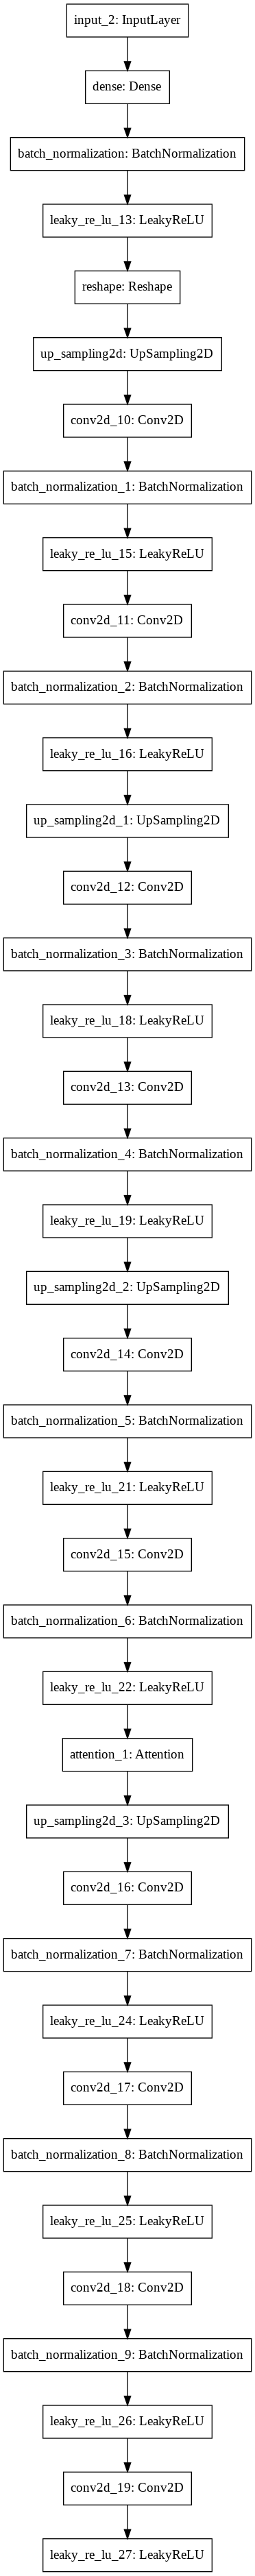

In [9]:
tf.keras.utils.plot_model(g_model)

## Create a WGAN-GP model

Now that we have defined our generator and discriminator models, we will
implement the WGAN-GP model. We will override the `train_step` for training.


In [16]:

class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interplated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper.
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add gradient penalty to the discriminator loss
        # 6. Return generator and discriminator losses as a loss dictionary.

        # Train discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images, training=True)
                # Get the logits for real images
                real_logits = self.discriminator(real_images, training=True)

                # Calculate discriminator loss using fake and real logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator now.
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}



## Create a callback that periodically saves generated images


In [17]:
from google.colab.patches import cv2_imshow
from PIL import Image


def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img, random_latent_vectors):
        self.num_img = num_img
        self.random_latent_vectors = random_latent_vectors

    def on_epoch_end(self, epoch, logs=None):
        #random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(self.random_latent_vectors)
        generated_images = (generated_images * 255)
        

        ims=[]
        for i in range(self.num_img):
            img = generated_images[i].numpy()
            #img=append(np.array(keras.preprocessing.image.array_to_img(img)))
            #img.save("generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
            ims.append(np.array(keras.preprocessing.image.array_to_img(img)))
        
        ims_tiled=concat_tile([[ims[0],ims[1],ims[2],ims[3],ims[4]],
                               [ims[5],ims[6],ims[7],ims[8],ims[9]],
                               [ims[10],ims[11],ims[12],ims[13],ims[14]],
                               [ims[15],ims[16],ims[17],ims[18],ims[19]],
                               [ims[20],ims[21],ims[22],ims[23],ims[24]]])
        #np.save('/content/drive/My Drive/ThesisDL/CELL_GAN/MF_CELLS/val_ims/'+'generated_img_{i}_{epoch}.png'.format(i=i, epoch=epoch),ims_tiled)
        im = Image.fromarray(ims_tiled)
        im.save('/content/drive/My Drive/ThesisDL/CELL_GAN/MF_CELLS/val_ims_l2_sa/'+'generated_img_{i}_{epoch}.png'.format(i=i, epoch=epoch))
        cv2_imshow(ims_tiled)



## Train the end-to-end model


Epoch 1/1000
181/181 [==============================] - ETA: 0s - d_loss: -4.3193 - g_loss: 6.7832

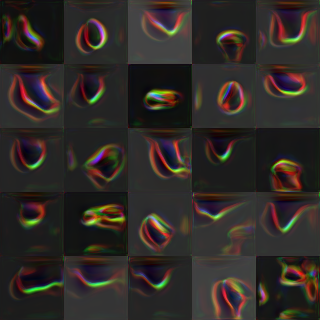

181/181 [==============================] - 290s 2s/step - d_loss: -4.2608 - g_loss: 6.7954
Epoch 2/1000
181/181 [==============================] - ETA: 0s - d_loss: -1.4865 - g_loss: 2.9998

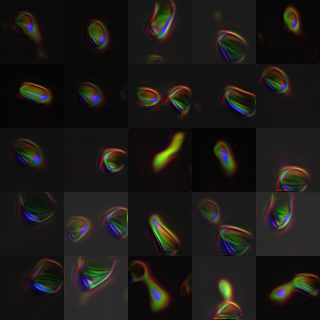

181/181 [==============================] - 285s 2s/step - d_loss: -1.4884 - g_loss: 2.9739
Epoch 3/1000
181/181 [==============================] - ETA: 0s - d_loss: -2.4433 - g_loss: 2.6202

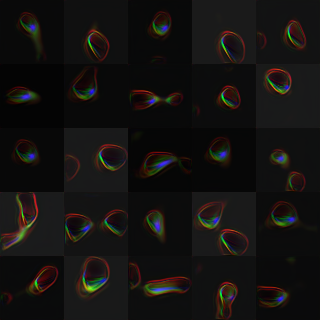

181/181 [==============================] - 285s 2s/step - d_loss: -2.4453 - g_loss: 2.4624
Epoch 4/1000
181/181 [==============================] - ETA: 0s - d_loss: -3.2850 - g_loss: 39.4320

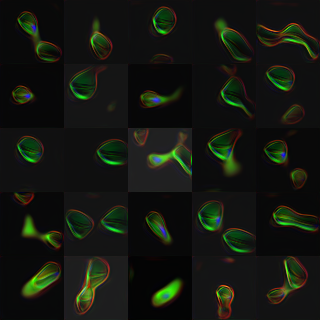

181/181 [==============================] - 285s 2s/step - d_loss: -3.2159 - g_loss: 39.8007
Epoch 5/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.2690 - g_loss: 1.4327

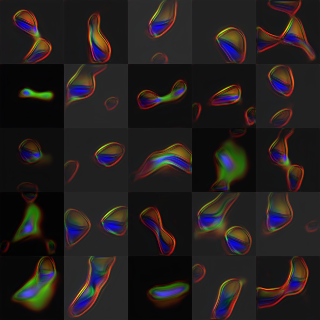

181/181 [==============================] - 285s 2s/step - d_loss: -0.3183 - g_loss: 1.2829
Epoch 6/1000
181/181 [==============================] - ETA: 0s - d_loss: 0.3485 - g_loss: -1.4379

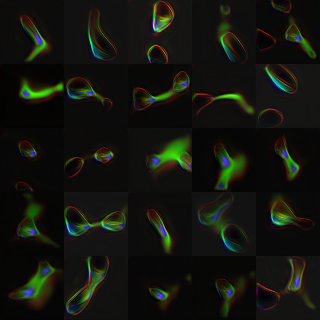

181/181 [==============================] - 285s 2s/step - d_loss: 0.3409 - g_loss: -1.3940
Epoch 7/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.8011 - g_loss: 4.5241

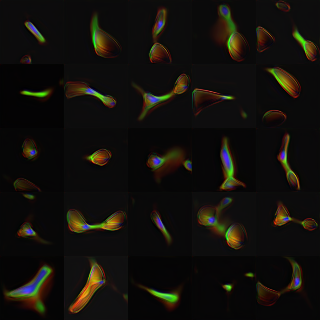

181/181 [==============================] - 285s 2s/step - d_loss: -0.7951 - g_loss: 4.4885
Epoch 8/1000
181/181 [==============================] - ETA: 0s - d_loss: -1.2409 - g_loss: 0.9933

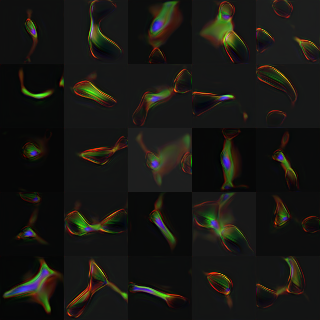

181/181 [==============================] - 285s 2s/step - d_loss: -1.2534 - g_loss: 1.0461
Epoch 9/1000
181/181 [==============================] - ETA: 0s - d_loss: -1.3917 - g_loss: 11.3876

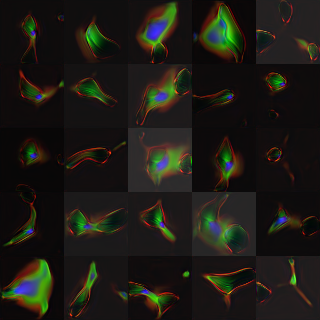

181/181 [==============================] - 285s 2s/step - d_loss: -1.5578 - g_loss: 11.3325
Epoch 10/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.3765 - g_loss: 4.0604

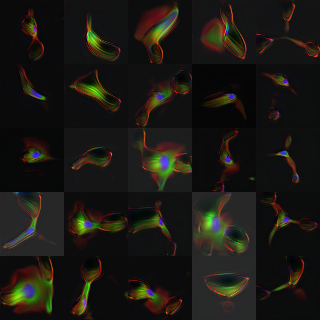

181/181 [==============================] - 285s 2s/step - d_loss: -0.3824 - g_loss: 4.0240
Epoch 11/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.8565 - g_loss: 2.4809

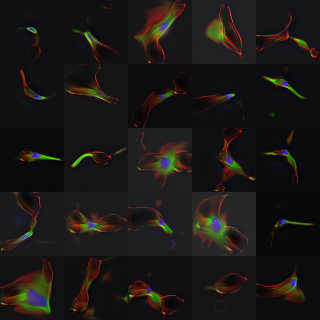

181/181 [==============================] - 285s 2s/step - d_loss: -0.8620 - g_loss: 2.4974
Epoch 12/1000
181/181 [==============================] - ETA: 0s - d_loss: -1.5920 - g_loss: 17.0479

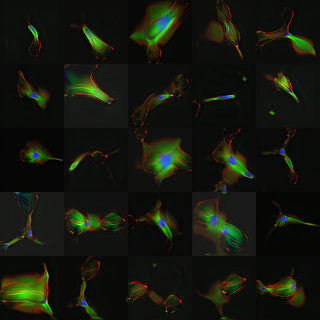

181/181 [==============================] - 285s 2s/step - d_loss: -1.5581 - g_loss: 16.9989
Epoch 13/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.6746 - g_loss: 2.1451

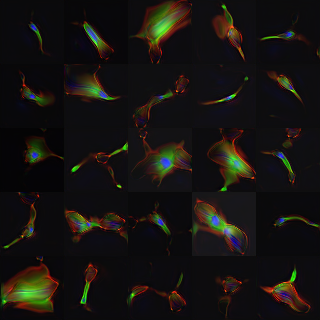

181/181 [==============================] - 285s 2s/step - d_loss: -0.6739 - g_loss: 2.1557
Epoch 14/1000
181/181 [==============================] - ETA: 0s - d_loss: -1.0244 - g_loss: 2.6807

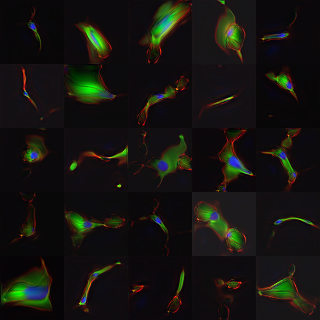

181/181 [==============================] - 285s 2s/step - d_loss: -1.0258 - g_loss: 2.6821
Epoch 15/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.6533 - g_loss: 7.5461

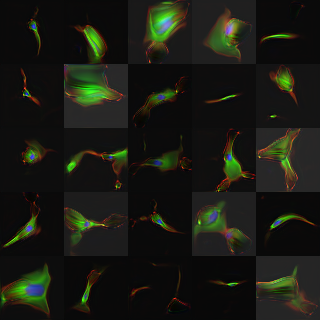

181/181 [==============================] - 285s 2s/step - d_loss: -0.6251 - g_loss: 7.4517
Epoch 16/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.3554 - g_loss: -5.5526

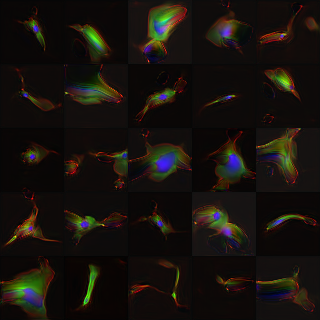

181/181 [==============================] - 285s 2s/step - d_loss: -0.2867 - g_loss: -5.3268
Epoch 17/1000
181/181 [==============================] - ETA: 0s - d_loss: 36.6338 - g_loss: 56.2850

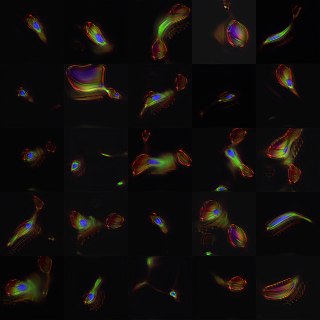

181/181 [==============================] - 285s 2s/step - d_loss: 36.1378 - g_loss: 62.9156
Epoch 18/1000
181/181 [==============================] - ETA: 0s - d_loss: 1.5014 - g_loss: 71.3011

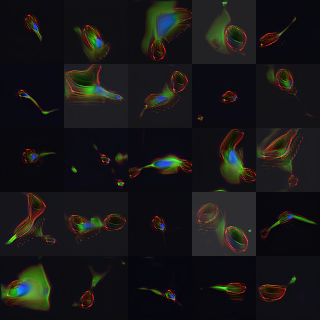

181/181 [==============================] - 285s 2s/step - d_loss: 1.4770 - g_loss: 70.8688
Epoch 19/1000
181/181 [==============================] - ETA: 0s - d_loss: -2.7525 - g_loss: 12.1771

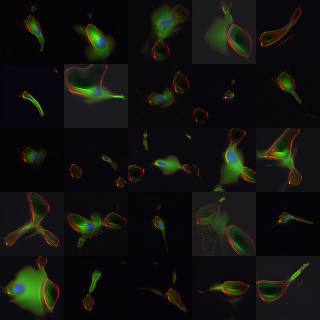

181/181 [==============================] - 285s 2s/step - d_loss: -2.6105 - g_loss: 12.1685
Epoch 20/1000
181/181 [==============================] - ETA: 0s - d_loss: -4.5800 - g_loss: 69.9389

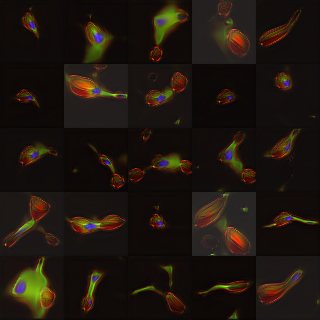

181/181 [==============================] - 285s 2s/step - d_loss: -4.2799 - g_loss: 69.3531
Epoch 21/1000
181/181 [==============================] - ETA: 0s - d_loss: 0.2893 - g_loss: -2.8115

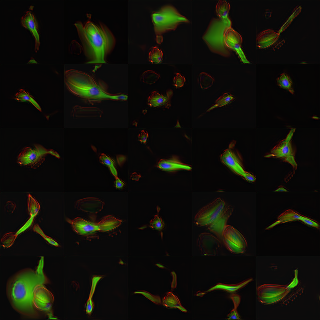

181/181 [==============================] - 285s 2s/step - d_loss: 0.2743 - g_loss: -2.7262
Epoch 22/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.4811 - g_loss: 10.0870

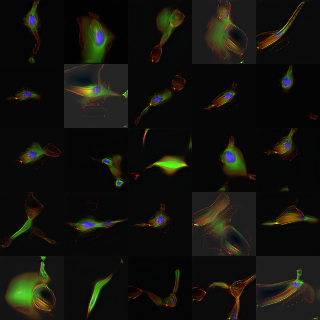

181/181 [==============================] - 285s 2s/step - d_loss: -0.4954 - g_loss: 10.0724
Epoch 23/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.2891 - g_loss: 22.6318

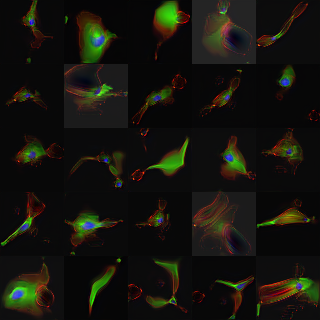

181/181 [==============================] - 285s 2s/step - d_loss: -0.2828 - g_loss: 22.5316
Epoch 24/1000
181/181 [==============================] - ETA: 0s - d_loss: 2.4063 - g_loss: 13.5887

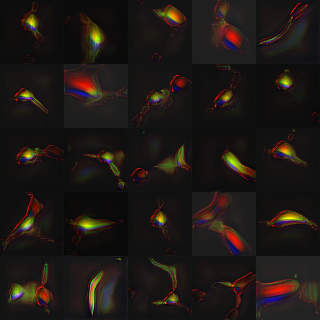

181/181 [==============================] - 285s 2s/step - d_loss: 1.9243 - g_loss: 13.2492
Epoch 25/1000
181/181 [==============================] - ETA: 0s - d_loss: 0.8006 - g_loss: 22.7834

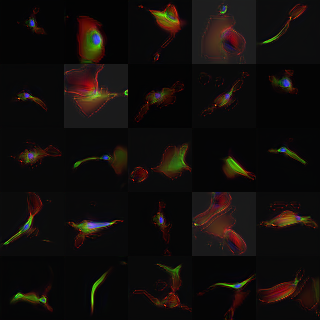

181/181 [==============================] - 285s 2s/step - d_loss: 0.7950 - g_loss: 22.7783
Epoch 26/1000
181/181 [==============================] - ETA: 0s - d_loss: -2.0185 - g_loss: 14.4276

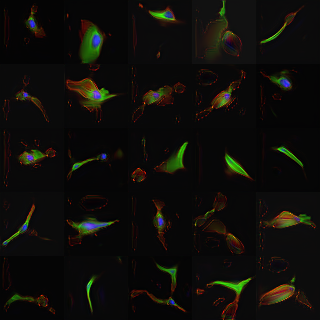

181/181 [==============================] - 285s 2s/step - d_loss: -2.0402 - g_loss: 14.3732
Epoch 27/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.1318 - g_loss: -11.5145

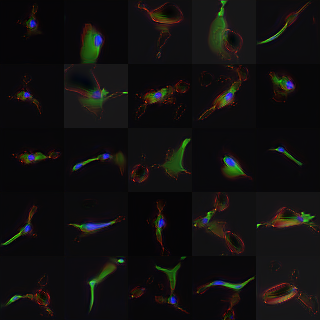

181/181 [==============================] - 285s 2s/step - d_loss: -0.1467 - g_loss: -11.4648
Epoch 28/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.2995 - g_loss: -29.7619

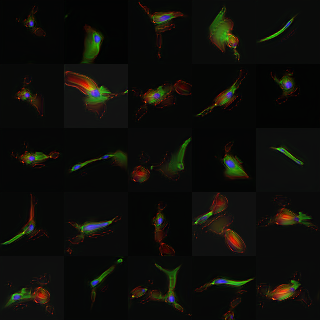

181/181 [==============================] - 285s 2s/step - d_loss: -0.4399 - g_loss: -29.6937
Epoch 29/1000
181/181 [==============================] - ETA: 0s - d_loss: 2.4271 - g_loss: -70.4127

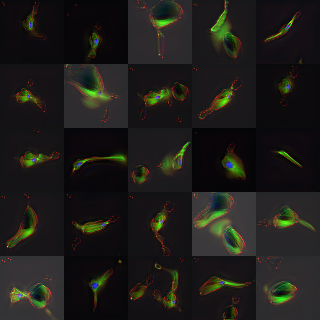

181/181 [==============================] - 285s 2s/step - d_loss: 2.4721 - g_loss: -68.9546
Epoch 30/1000
181/181 [==============================] - ETA: 0s - d_loss: 9.4460 - g_loss: 67.1788

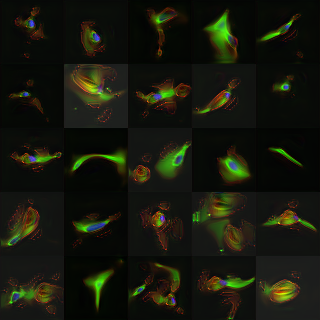

181/181 [==============================] - 285s 2s/step - d_loss: 9.3649 - g_loss: 66.9724
Epoch 31/1000
181/181 [==============================] - ETA: 0s - d_loss: 2.8022 - g_loss: 9.0061 

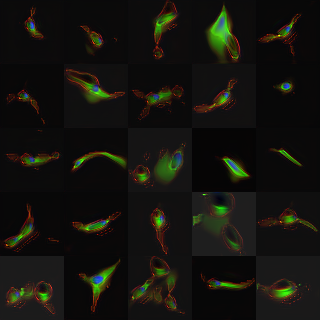

181/181 [==============================] - 285s 2s/step - d_loss: 3.6452 - g_loss: 7.8388
Epoch 32/1000
181/181 [==============================] - ETA: 0s - d_loss: 4.4666 - g_loss: -82.2963

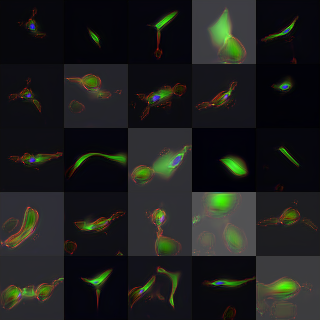

181/181 [==============================] - 285s 2s/step - d_loss: 4.3478 - g_loss: -81.5223
Epoch 33/1000
181/181 [==============================] - ETA: 0s - d_loss: 1.5899 - g_loss: -12.0505

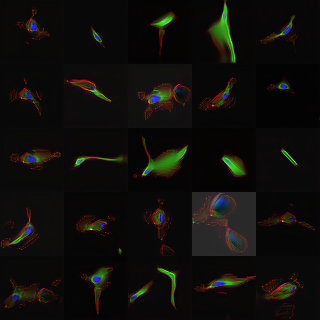

181/181 [==============================] - 285s 2s/step - d_loss: 1.7732 - g_loss: -12.1345
Epoch 34/1000
181/181 [==============================] - ETA: 0s - d_loss: 3.0295 - g_loss: -18.8599

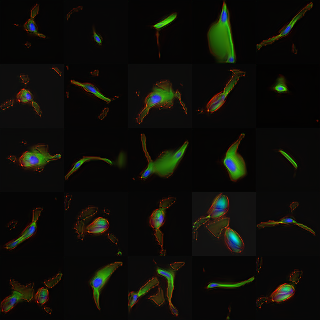

181/181 [==============================] - 285s 2s/step - d_loss: 3.0479 - g_loss: -18.5805
Epoch 35/1000
181/181 [==============================] - ETA: 0s - d_loss: 3.6309 - g_loss: -24.2232

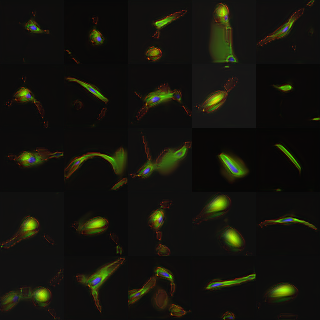

181/181 [==============================] - 285s 2s/step - d_loss: 3.4537 - g_loss: -24.4871
Epoch 36/1000
181/181 [==============================] - ETA: 0s - d_loss: 7.7943 - g_loss: -56.2248

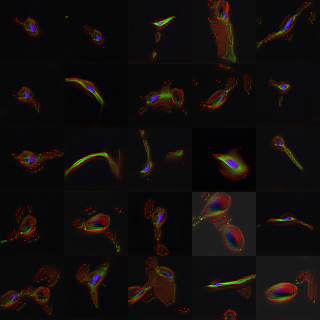

181/181 [==============================] - 285s 2s/step - d_loss: 9.9033 - g_loss: -53.6547
Epoch 37/1000
181/181 [==============================] - ETA: 0s - d_loss: -9.7921 - g_loss: -133.4391

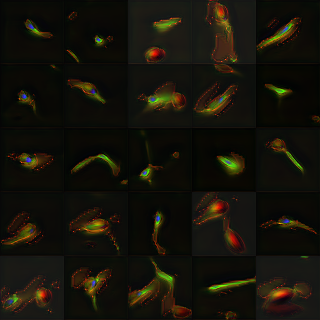

181/181 [==============================] - 285s 2s/step - d_loss: -10.4383 - g_loss: -143.1325
Epoch 38/1000
181/181 [==============================] - ETA: 0s - d_loss: -27.1982 - g_loss: 5523.7993

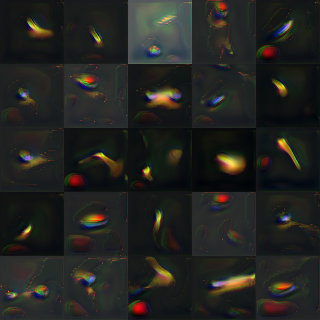

181/181 [==============================] - 285s 2s/step - d_loss: -136.6030 - g_loss: 5547.1364
Epoch 39/1000
181/181 [==============================] - ETA: 0s - d_loss: 619.6457 - g_loss: 7207.1505

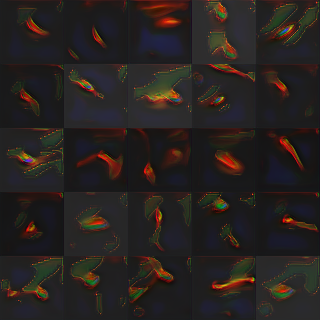

181/181 [==============================] - 285s 2s/step - d_loss: 609.0019 - g_loss: 7310.5718
Epoch 40/1000
181/181 [==============================] - ETA: 0s - d_loss: 142.0031 - g_loss: 3317.1846

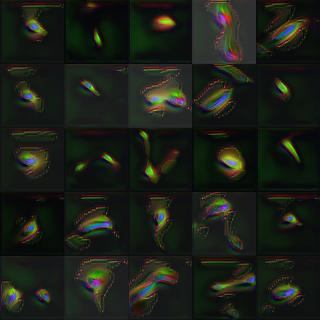

181/181 [==============================] - 285s 2s/step - d_loss: 172.1033 - g_loss: 3312.1116
Epoch 41/1000
181/181 [==============================] - ETA: 0s - d_loss: 504.8221 - g_loss: 5605.8593

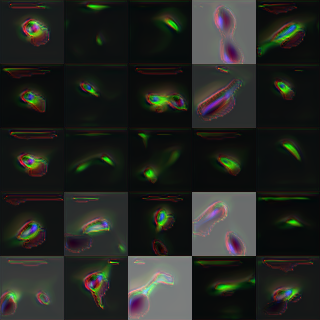

181/181 [==============================] - 285s 2s/step - d_loss: 491.9120 - g_loss: 5587.1964
Epoch 42/1000
181/181 [==============================] - ETA: 0s - d_loss: 191.2909 - g_loss: 3807.9861

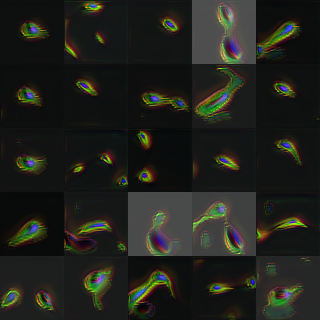

181/181 [==============================] - 285s 2s/step - d_loss: 162.9097 - g_loss: 3805.2122
Epoch 43/1000
181/181 [==============================] - ETA: 0s - d_loss: 188.2335 - g_loss: -844.3197

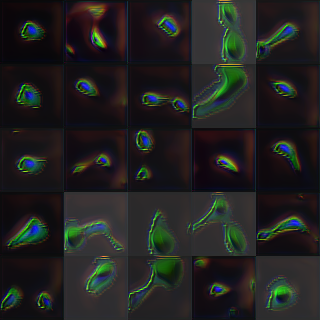

181/181 [==============================] - 285s 2s/step - d_loss: 187.3632 - g_loss: -839.1883
Epoch 44/1000
181/181 [==============================] - ETA: 0s - d_loss: 1.7430 - g_loss: 162.7261

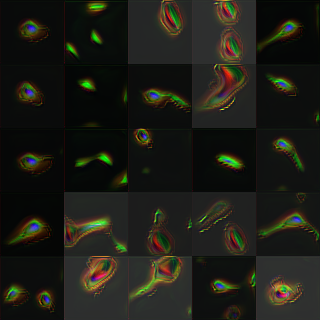

181/181 [==============================] - 285s 2s/step - d_loss: 1.7699 - g_loss: 163.3848
Epoch 45/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.2910 - g_loss: 144.2697

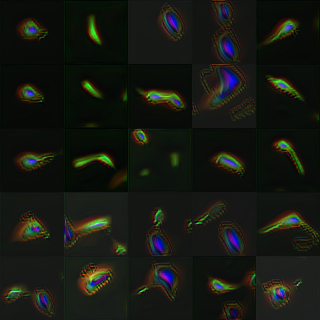

181/181 [==============================] - 285s 2s/step - d_loss: -0.2323 - g_loss: 144.6255
Epoch 46/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.8151 - g_loss: 96.3982

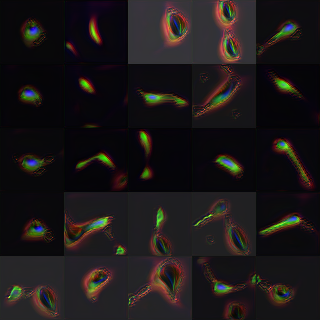

181/181 [==============================] - 285s 2s/step - d_loss: -0.7535 - g_loss: 96.0576
Epoch 47/1000
181/181 [==============================] - ETA: 0s - d_loss: -0.1000 - g_loss: -148.5964

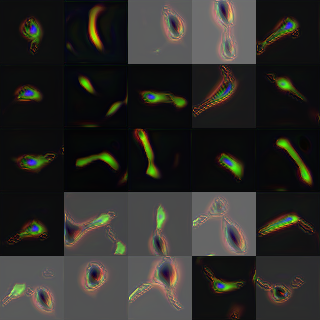

181/181 [==============================] - 285s 2s/step - d_loss: -0.0588 - g_loss: -148.6645
Epoch 48/1000
181/181 [==============================] - ETA: 0s - d_loss: 0.1548 - g_loss: 3.0278

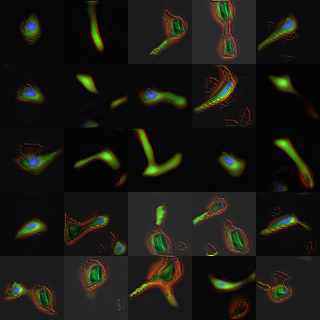

181/181 [==============================] - 285s 2s/step - d_loss: 0.1361 - g_loss: 3.0250
Epoch 49/1000
181/181 [==============================] - ETA: 0s - d_loss: 0.3009 - g_loss: -51.0487

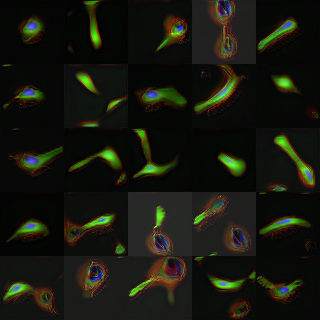

181/181 [==============================] - 285s 2s/step - d_loss: 0.5343 - g_loss: -50.7588
Epoch 50/1000
181/181 [==============================] - ETA: 0s - d_loss: 0.9019 - g_loss: 53.7694

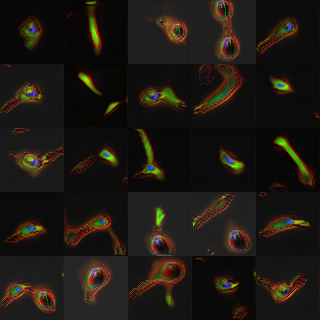

181/181 [==============================] - 285s 2s/step - d_loss: 0.3262 - g_loss: 56.1155
Epoch 51/1000
 53/181 [=======>......................] - ETA: 3:18 - d_loss: 22.2040 - g_loss: 455.4643

In [ ]:
import cv2

# Optimizer for both the networks
# learning_rate=0.0002, beta_1=0.5 are recommened
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions to be used for discrimiator
# This should be (fake_loss - real_loss)
# We will add the gradient penalty later to this loss function
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions to be used for generator
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Epochs to train
epochs = 1000

# Callbacks
num_val_ims=25
random_latent_vectors = tf.random.normal((num_val_ims,noise_dim))
cbk = GANMonitor(num_img=num_val_ims,random_latent_vectors=random_latent_vectors)
chpcbck=tf.keras.callbacks.ModelCheckpoint(filepath=content+'/model_l2_wd_sa/model')

# Get the wgan model
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the wgan model
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)
BATCH_SIZE=128

# Start training
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk,chpcbck])


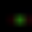

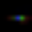

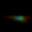

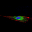

In [ ]:
t_ims_4x4=np.zeros(train_images.shape).astype('float32')
t_ims_8x8=np.zeros(train_images.shape).astype('float32')
t_ims_16x16=np.zeros(train_images.shape).astype('float32')

finsize=32;
for i,im in enumerate(train_images):

  t_ims_4x4[i,:,:,:]=cv2.resize(cv2.resize(im,(4,4)),(finsize,finsize))
  t_ims_8x8[i,:,:,:]=cv2.resize(cv2.resize(im,(8,8)),(finsize,finsize))
  t_ims_16x16[i,:,:,:]=cv2.resize(cv2.resize(im,(16,16)),(finsize,finsize))

cv2_imshow(t_ims_4x4[0,:,:,:]* 127.5 + 127.5)
cv2_imshow(t_ims_8x8[0,:,:,:]* 127.5 + 127.5)
cv2_imshow(t_ims_16x16[0,:,:,:]* 127.5 + 127.5)
cv2_imshow(train_images[0,:,:,:]* 127.5 + 127.5)

In [ ]:
epochs=20
wgan.fit(t_ims_4x4, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])
wgan.fit(t_ims_8x8, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])
wgan.fit(t_ims_16x16, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])
wgan.fit(train_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

Display the last generated images:


In [ ]:
from IPython.display import Image, display

display(Image("generated_img_0_19.png"))
display(Image("generated_img_1_19.png"))
display(Image("generated_img_2_19.png"))
